In [38]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import math


In [40]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deepanshurao0001/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/deepanshurao0001/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [44]:
def load_newsgroups():
    newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    df = pd.DataFrame({'text': newsgroups.data, 'category': newsgroups.target})
    return df, newsgroups.target_names


In [46]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

In [48]:
newsgroups_df, target_names = load_newsgroups()


In [49]:
print(newsgroups_df.info())
print(newsgroups_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      18846 non-null  object
 1   category  18846 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 294.6+ KB
None
                                                text  category
0  \n\nI am sure some bashers of Pens fans are pr...        10
1  My brother is in the market for a high-perform...         3
2  \n\n\n\n\tFinally you said what you dream abou...        17
3  \nThink!\n\nIt's the SCSI card doing the DMA t...         3
4  1)    I have an old Jasmine drive which I cann...         4


category
10    999
15    997
8     996
9     994
11    991
7     990
13    990
5     988
14    987
2     985
12    984
3     982
6     975
1     973
4     963
17    940
16    910
0     799
18    775
19    628
Name: count, dtype: int64


<Axes: title={'center': 'Category Distribution'}, xlabel='category'>

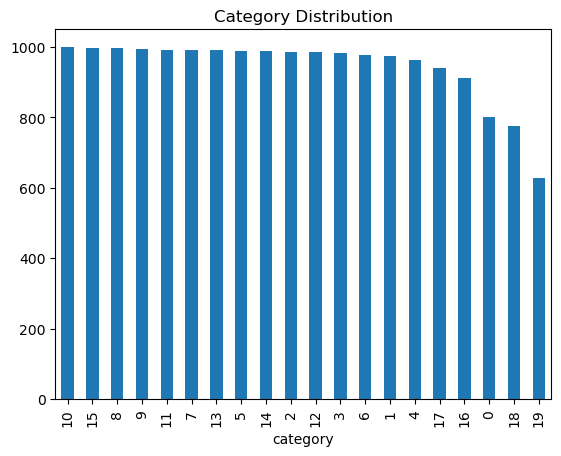

In [50]:
print(newsgroups_df['category'].value_counts())
newsgroups_df['category'].value_counts().plot(kind='bar', title='Category Distribution')



<Axes: title={'center': 'Average Text Length by Category'}, xlabel='category'>

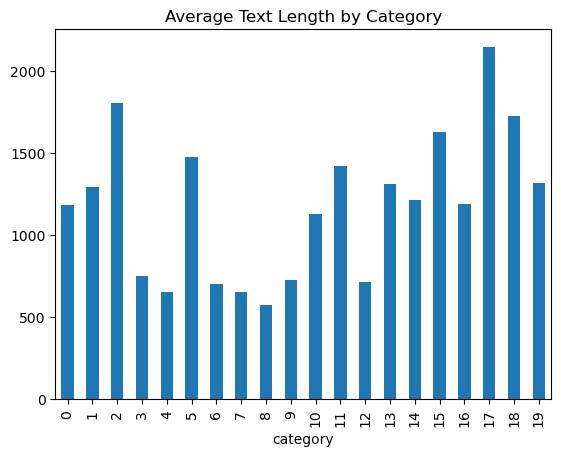

In [51]:
newsgroups_df['text_length'] = newsgroups_df['text'].apply(len)
newsgroups_df.groupby('category')['text_length'].mean().plot(kind='bar', title='Average Text Length by Category')



In [55]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(newsgroups_df['text'])
word_freq = np.asarray(word_counts.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame(list(zip(words, word_freq)), columns=['word', 'frequency'])
print(word_freq_df.sort_values(by='frequency', ascending=False))


      word  frequency
0       ax      62396
8     like       6525
2      don       6524
12  people       6458
6     just       6172
7     know       5763
16     use       5027
14   think       5001
15    time       4867
10     max       4637
1     does       4504
11     new       4089
5     good       3921
3      edu       3753
4      god       3399
19     way       3398
9     make       3349
18      ve       3143
17    used       3048
13     say       3015


In [57]:
newsgroups_df['text'] = newsgroups_df['text'].fillna("").apply(lambda x: " ".join(preprocess_text(x)))

In [58]:
class_frequencies = newsgroups_df['category'].value_counts().to_dict()

In [60]:
train_df, test_df = train_test_split(newsgroups_df, test_size=0.3, stratify=newsgroups_df['category'], random_state=42)

In [61]:
print("\nRunning Baseline Model (TF-IDF + Random Forest)...")
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_baseline = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
X_test_baseline = tfidf_vectorizer.transform(test_df['text']).toarray()
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_model.fit(X_train_baseline, train_df['category'])
baseline_predictions = baseline_model.predict(X_test_baseline)


Running Baseline Model (TF-IDF + Random Forest)...


In [62]:
print("\nBaseline Model Results:")
print(classification_report(test_df['category'], baseline_predictions, target_names=target_names))



Baseline Model Results:
                          precision    recall  f1-score   support

             alt.atheism       0.41      0.30      0.35       240
           comp.graphics       0.52      0.49      0.50       292
 comp.os.ms-windows.misc       0.57      0.56      0.57       296
comp.sys.ibm.pc.hardware       0.45      0.48      0.47       295
   comp.sys.mac.hardware       0.57      0.53      0.55       289
          comp.windows.x       0.59      0.65      0.62       296
            misc.forsale       0.65      0.70      0.67       293
               rec.autos       0.35      0.59      0.44       297
         rec.motorcycles       0.56      0.51      0.53       299
      rec.sport.baseball       0.56      0.50      0.53       298
        rec.sport.hockey       0.65      0.75      0.70       300
               sci.crypt       0.69      0.65      0.67       297
         sci.electronics       0.42      0.45      0.44       295
                 sci.med       0.62      0.63     

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define globally so same vectorizer is used for train/test
vectorizer = TfidfVectorizer(max_features=1000)

def afe_mert_features(df, fit=True):
    if fit:
        return vectorizer.fit_transform(df['text'])
    else:
        return vectorizer.transform(df['text'])

In [64]:
print("\nRunning AFE-MERT Model (Random Forest)...")
X_train_afe = afe_mert_features(train_df, class_frequencies)
X_test_afe = afe_mert_features(test_df, class_frequencies)
afe_model = RandomForestClassifier(n_estimators=100, random_state=42)
afe_model.fit(X_train_afe, train_df['category'])
afe_predictions = afe_model.predict(X_test_afe)


Running AFE-MERT Model (Random Forest)...


In [65]:
print("\nAFE-MERT Model Results:")
print(classification_report(test_df['category'], afe_predictions, target_names=target_names))


AFE-MERT Model Results:
                          precision    recall  f1-score   support

             alt.atheism       0.07      0.04      0.05       240
           comp.graphics       0.10      0.05      0.06       292
 comp.os.ms-windows.misc       0.37      0.42      0.40       296
comp.sys.ibm.pc.hardware       0.04      0.02      0.03       295
   comp.sys.mac.hardware       0.05      0.08      0.06       289
          comp.windows.x       0.24      0.17      0.20       296
            misc.forsale       0.02      0.01      0.01       293
               rec.autos       0.07      0.10      0.08       297
         rec.motorcycles       0.16      0.15      0.15       299
      rec.sport.baseball       0.03      0.04      0.03       298
        rec.sport.hockey       0.09      0.08      0.09       300
               sci.crypt       0.07      0.10      0.08       297
         sci.electronics       0.08      0.03      0.05       295
                 sci.med       0.08      0.13     

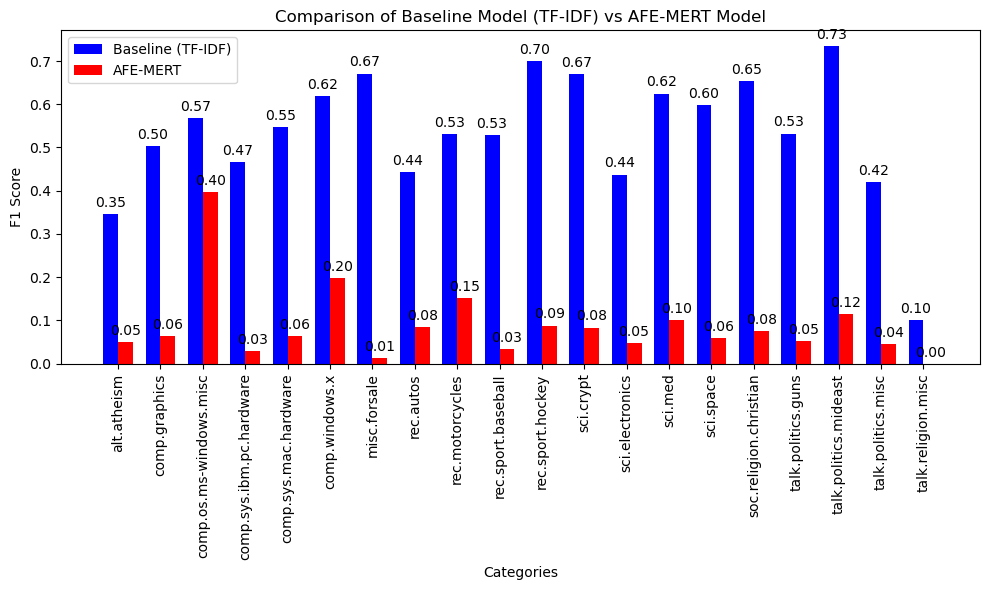

In [66]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

baseline_report = classification_report(test_df['category'], baseline_predictions, target_names=target_names, output_dict=True)
afe_report = classification_report(test_df['category'], afe_predictions, target_names=target_names, output_dict=True)

baseline_f1_scores = [baseline_report[class_name]['f1-score'] for class_name in target_names]
afe_f1_scores = [afe_report[class_name]['f1-score'] for class_name in target_names]

x = np.arange(len(target_names))  
width = 0.35  
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, baseline_f1_scores, width, label='Baseline (TF-IDF)', color='b')
rects2 = ax.bar(x + width/2, afe_f1_scores, width, label='AFE-MERT', color='r')

ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('Comparison of Baseline Model (TF-IDF) vs AFE-MERT Model')
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=90)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()

plt.show()